# Classifying Mobile User Activity 

## Import packages

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, roc_auc_score, roc_curve

## Import data and check for missingness

In [2]:
# read in csv file
df = pd.read_csv("../data/user_behavior_dataset.csv")

In [3]:
df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [20]:
df['User Behavior Class'].value_counts()

User Behavior Class
2    146
3    143
4    139
5    136
1    136
Name: count, dtype: int64

There are only 700 rows in the entire dataset, which means we have a small sample size to build a model from, but we can still split into a small train and test set and test out logistic regression and perhaps a tree-based model.

In [7]:
df.shape

(700, 11)

There is no missing data in the data set, which is rare and very easy to work with, as we won't have to worry about imputing missing values.

In [6]:
# check data for missingness
df.isna().sum()

User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

In [14]:
# check datatypes
df.dtypes

User ID                         int64
Device Model                   object
Operating System               object
App Usage Time (min/day)        int64
Screen On Time (hours/day)    float64
Battery Drain (mAh/day)         int64
Number of Apps Installed        int64
Data Usage (MB/day)             int64
Age                             int64
Gender                         object
User Behavior Class             int64
dtype: object

In [164]:
# Split the dataframe into input variables vs target variable
X = df.iloc[ : , 1:-1].values
Y = df.iloc[ : , 10].values

In [165]:
X[ : , 0]

array(['Google Pixel 5', 'OnePlus 9', 'Xiaomi Mi 11', 'Google Pixel 5',
       'iPhone 12', 'Google Pixel 5', 'Samsung Galaxy S21', 'OnePlus 9',
       'Samsung Galaxy S21', 'iPhone 12', 'Google Pixel 5', 'OnePlus 9',
       'OnePlus 9', 'Xiaomi Mi 11', 'iPhone 12', 'Google Pixel 5',
       'OnePlus 9', 'iPhone 12', 'Google Pixel 5', 'iPhone 12',
       'Samsung Galaxy S21', 'OnePlus 9', 'Samsung Galaxy S21',
       'Google Pixel 5', 'OnePlus 9', 'Samsung Galaxy S21', 'iPhone 12',
       'Google Pixel 5', 'OnePlus 9', 'Samsung Galaxy S21',
       'Xiaomi Mi 11', 'Xiaomi Mi 11', 'Google Pixel 5', 'Google Pixel 5',
       'Xiaomi Mi 11', 'Samsung Galaxy S21', 'iPhone 12',
       'Samsung Galaxy S21', 'OnePlus 9', 'Samsung Galaxy S21',
       'Xiaomi Mi 11', 'OnePlus 9', 'Samsung Galaxy S21',
       'Samsung Galaxy S21', 'Xiaomi Mi 11', 'Xiaomi Mi 11', 'OnePlus 9',
       'Samsung Galaxy S21', 'Google Pixel 5', 'OnePlus 9',
       'Xiaomi Mi 11', 'Xiaomi Mi 11', 'Samsung Galaxy S21',
    

We created dummy variables from the categorical variables, or numeric representations of each category in a column, to be used in modeling, as non-numeric data cannot be used directly as an input into logistic regression models. 

In [166]:
# Creating a dummy variable
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), [0, 1, 8])  # Apply OneHotEncoder to columns 0, 1, and 8
    ], 
    remainder='passthrough'  # Keep the rest of the columns as they are
)
X = column_transformer.fit_transform(X)

Preserve the column names of the data.

In [48]:
column_transformer.get_feature_names_out()

array(['onehot__x0_Google Pixel 5', 'onehot__x0_OnePlus 9',
       'onehot__x0_Samsung Galaxy S21', 'onehot__x0_Xiaomi Mi 11',
       'onehot__x0_iPhone 12', 'onehot__x1_Android', 'onehot__x1_iOS',
       'onehot__x8_Female', 'onehot__x8_Male', 'remainder__x2',
       'remainder__x3', 'remainder__x4', 'remainder__x5', 'remainder__x6',
       'remainder__x7'], dtype=object)

In [162]:
X.shape

(700, 9)

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

I have a few hypotheses about the data we are using for modeling based on the exploratory data analysis, so I am going to run an initial exploratory logistic regression in order to test those theories.

The first hypothesis is that the Device Model variable is not going to have a big impact on predicting the User Behavior class, but the Operating System will have some impact. 

The second hypothesis is that age will not have a big impact on predicting the User Behavior class.

The third hypothesis is that since so many of the numeric variables are highly correlated with each other, also known as multicollinearity, the logistic regression model has difficulty determining which variable is driving the relationship with the outcome. As a result, the estimated coefficients (weights) can become highly sensitive to small changes in the data. This instability makes it hard to interpret the contribution of individual variables and can lead to unreliable coefficient estimates. This may be the biggest issue. We can test the multicollinearity by looking at the Variance Inflation Factor (VIF) when we build this inital model. If the VIF is in fact a problem, there are several things we can do do remediate it, such as removing some of the correlated features and only leaving one, PCA, or regularization.

Another thing to note here: I one-hot encoded the categorical variables, so that each value in the variable became it's own column. Techinically, when you use one-hot encoding with logistic regression (or any other linear models), it's often recommended to remove one of the encoded variables to avoid the problem of multicollinearity, which occurs when the independent variables are highly correlated with each other. This is known as the dummy variable trap. The model cannot uniquely estimate the relationship of each variable with the outcome because one variable is perfectly predictable from the others.

For this version of the model, I am leaving all of the dummy variables in the model, but I will remove one of the one-hot encoded columns for each variable in the next version.

In [51]:
# scale data to be the same scale
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

In [52]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

LogisticRegression()

In [53]:
y_pred = classifier.predict(X_test)

In [54]:
y_pred

array([4, 1, 1, 2, 3, 2, 2, 1, 4, 3, 1, 1, 2, 1, 3, 4, 5, 1, 3, 2, 5, 4,
       3, 4, 4, 2, 3, 5, 2, 5, 1, 3, 1, 3, 4, 5, 5, 1, 1, 2, 3, 4, 1, 3,
       2, 5, 3, 3, 1, 3, 2, 2, 2, 1, 5, 5, 3, 1, 4, 2, 3, 2, 1, 2, 5, 2,
       5, 1, 5, 5, 1, 2, 3, 2, 3, 2, 5, 4, 4, 4, 2, 1, 4, 3, 4, 4, 5, 3,
       3, 1, 1, 4, 2, 3, 4, 2, 2, 1, 3, 5, 3, 3, 1, 1, 3, 4, 5, 1, 4, 4,
       5, 4, 4, 3, 3, 2, 4, 3, 4, 3, 3, 4, 5, 4, 5, 2, 3, 5, 4, 5, 3, 2,
       1, 3, 2, 3, 5, 2, 1, 2])

In [55]:
cm = confusion_matrix(Y_test, y_pred, labels = [1, 2, 3, 4, 5])

In [56]:
cm

array([[27,  0,  0,  0,  0],
       [ 0, 29,  0,  0,  0],
       [ 0,  0, 34,  0,  0],
       [ 0,  0,  0, 27,  0],
       [ 0,  0,  0,  0, 23]])

<Axes: >

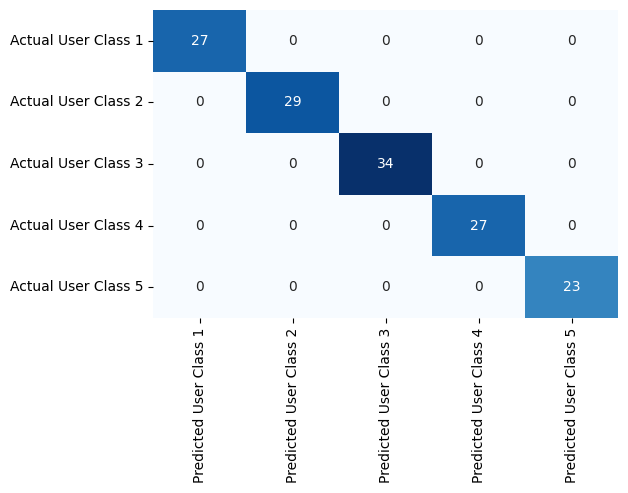

In [57]:
# Create a confusion matrix heatmap with labels using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted User Class 1', 'Predicted User Class 2', 'Predicted User Class 3', 'Predicted User Class 4', 'Predicted User Class 5'], 
            yticklabels=['Actual User Class 1', 'Actual User Class 2', 'Actual User Class 3', 'Actual User Class 4', 'Actual User Class 5'])

Overall, we were able to perfectly fit a logistic regression model to the User Behavior Classes. To me, this indicates a few possibilities:

1. Variables like Screen On Time are so highly correlated with the User Behavior Class that this input variable basically gives away the answer as to a user's behavior class. In the EDA notebook, we saw that a boxplot of screen time almost perfectly breaks the users into user behavior classes by Screen On Time. This variable, plus some of the other numeric variables lead directly to the answer.

2. Our model is likely overfit due to a large number of inputs and a small sample size.

## Feature Reduction

The model seems to predict user behavior class well, but for the sake of using less resources in deployment and avoiding overfitting, we can reduce the number of model inputs and still have a decent model.

We will use gender, operating system, and screen time, since all of these features had a relationship with User Behavior class, and we want to avoid multicollinearity, therefore leaving out the other highly correlated numeric variables.

In [167]:
X = X[:,[5,7,10]]
X

array([[1.0, 0.0, 6.4],
       [1.0, 1.0, 4.7],
       [1.0, 0.0, 4.0],
       ...,
       [1.0, 1.0, 3.1],
       [1.0, 0.0, 1.7],
       [1.0, 1.0, 5.4]], dtype=object)

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=66)

In [66]:
# scale data to be the same scale
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

In [67]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

LogisticRegression()

In [68]:
y_pred = classifier.predict(X_test)

In [69]:
cm = confusion_matrix(Y_test, y_pred, labels = [1, 2, 3, 4, 5])

## Logistic Regression with Reduced Features

This model does not perform as well as the previous model that had issues with multicollinearity and over-fitting. Gender and Operating System may not have be as strong of predictors as some of the other numeric variables that we included in the first model. I am going to try a different method to see if I can get better performance.

<Axes: >

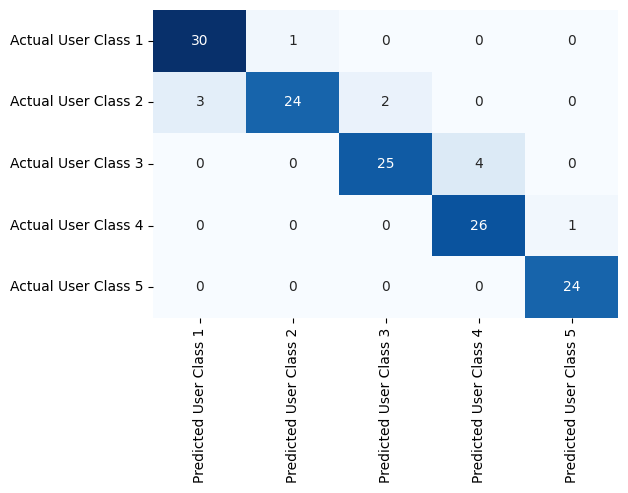

In [70]:
# Create a confusion matrix heatmap with labels using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted User Class 1', 'Predicted User Class 2', 'Predicted User Class 3', 'Predicted User Class 4', 'Predicted User Class 5'], 
            yticklabels=['Actual User Class 1', 'Actual User Class 2', 'Actual User Class 3', 'Actual User Class 4', 'Actual User Class 5'])

## PCA

The model built with fewer input features and removing inputs that would cause multicollinearity was decent, but we can definitely achieve higher metrics with this problem since the input data is so correlated with the target variable. In the next model, I tried out using PCA. PCA, or Principal Components Analysis, reduces the dimensionality and has the effect of guarding against multicollinearity. In short, PCA compacts the variance for a number a variables into a reduced number of components or values that represent the most valuable information in the original variables.

By using PCA on the 5 numeric variables (App Usage Time, Screen On Time, Battery Drain, Number of Apps Installed, Data Usage (MB/day)), we are able to reduce the feature space to one component or one dimension. This make sense, because all of these variables are so highly correlated with one another. The one component we create from the 5 variables accounts for ~95% of the variance in the variables.

We will now build a new model that uses just this component as an input.

In [112]:
# reset X
X = df.iloc[ : , 3:8].values
Y = df.iloc[ : , 10].values

In [113]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [114]:
# Initialize PCA and fit on the training data
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check how many components were selected
print("Number of components selected:", pca.n_components_)

Number of components selected: 1


In [117]:
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.95890295]


## Logistic Regression with PCA

After building another logistic regression model that uses the component we created using PCA as the input, you can see that the model has 100% accuracy, as our first model with all of the features had. The difference between this model and the first model is that we reduced the dimensionality of the input features, to account for multicollinearity and to hopefully reduce over-fitting. 

Accuracy: 1.0


<Axes: >

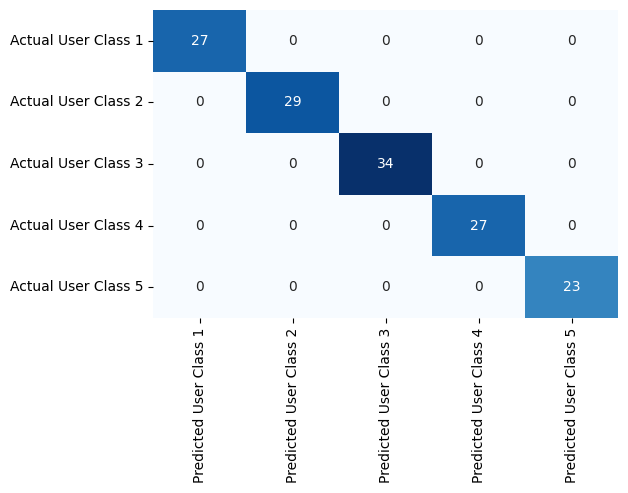

In [118]:
# Initialize and train the logistic regression model
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_pca, Y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(Y_test, y_pred, labels = [1, 2, 3, 4, 5])

# Create a confusion matrix heatmap with labels using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted User Class 1', 'Predicted User Class 2', 'Predicted User Class 3', 'Predicted User Class 4', 'Predicted User Class 5'], 
            yticklabels=['Actual User Class 1', 'Actual User Class 2', 'Actual User Class 3', 'Actual User Class 4', 'Actual User Class 5'])

The latest model we have built has perfect metrics when predicting on a test data set that we separated from the sample. Aside from accuracy, some of the metrics that we look at are Precision, Recall, and the F1 score. 

Precision measures how many of the users that were predicted to be in a given user behavior class are actually in that class. In a multi-class problem, every single class has it's own precision value. We can see in the chart that our model has 100% precision.

Recall meausre how many of the users that are actually in each user behavior class were identified correctly be the model. Although it is similar to precision, it's different in that the denominator is the pool of users who were actually in each class. For precision, the denominator is the pool of users who were predicted in each class. The chart shows that our model has 100% recall.

The F1 score combines precision and recall into a single score by taking their harmonic mean. F1 score is the most useful in problems that have imbalanced data, because it strikes a balance between precision and recall. In our case, the F1 score is 100%.

         PCA_numeric_coef  PCA_numeric_intercepts
Class 1         -8.071652               -8.612325
Class 2         -3.151190                2.577017
Class 3          0.335084                5.978993
Class 4          3.665912                4.153371
Class 5          7.221846               -4.097055
{'1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 27.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 29.0}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34.0}, '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 27.0}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 140.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 140.0}}


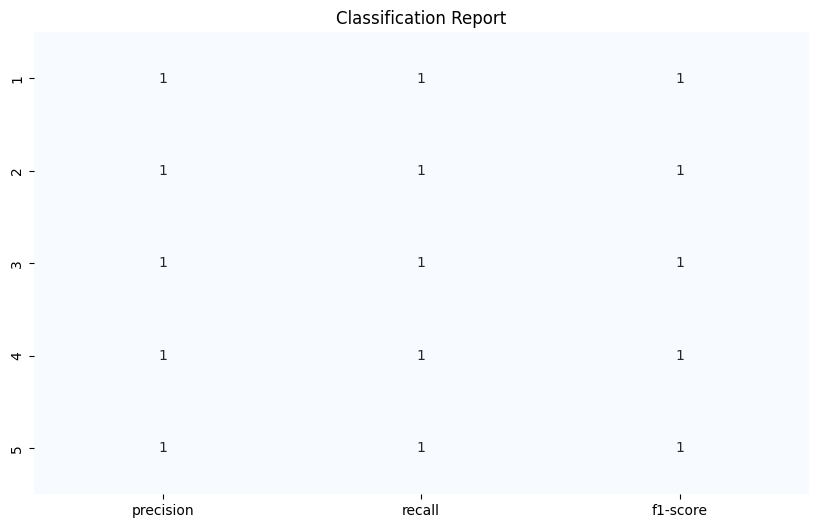

Accuracy: 1.0


In [159]:
# Coefficients and intercept
# Create a DataFrame for the coefficients
coef_df = pd.DataFrame(classifier.coef_, columns=['PCA_numeric_coef'])

# Add a column for the intercept (bias term) with multiple intercept values
coef_df['PCA_numeric_intercepts'] = classifier.intercept_

coef_df.index = ['Class 1','Class 2','Class 3','Class 4','Class 5']
print(coef_df.head())

# Generate the classification report as a dictionary
report = classification_report(Y_test, y_pred, output_dict=True)
print(report)

report_df = pd.DataFrame(report)

# Plot the heatmap of the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:3,:5].T, annot=True, cmap="Blues", cbar=False)
plt.title('Classification Report')
plt.show()

# Accuracy
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)


## Discarded Models

I did attempt a few other ways of reducing the dimensionality and accounting for multicollinearity in the model. I tried building an interaction variable between all of the numeric variables and then using that as the input to the model. Interaction variables account for multicollinearity because they create a mathematical representation of the relationships between the correlated variables (for example, using an input that is a product of two or more correlated input features). 

The model I created using an interaction feature as an input did not perform well, an was especially bad at predicting classes 1 and 3. I didn't end up pursuing this method further, as I was eager to try PCA as a way of accomplishing a similar feat.

In [96]:
# # Create interaction term between numeric variables (product of the 5 categories)
# interaction_term = np.prod(X, axis=1)  # Multiply across the rows (axis=1)

# # Add the interaction term as the 6th column in X
# X_with_interaction = np.column_stack((X, interaction_term))

# print(X_with_interaction.shape)

# X_interaction_only = X_with_interaction[ :, 5]

# print(X_interaction_only)

(700, 6)
[3.53953351e+11 6.64709663e+10 4.83026790e+09 9.37819664e+10
 6.29888261e+10 3.67400880e+09 3.20280308e+11 2.55377434e+12
 4.42045504e+11 5.34366443e+11 8.88908580e+07 6.02065500e+10
 4.71236207e+11 6.45230424e+10 7.39091964e+10 2.28774553e+12
 3.28506900e+09 1.00221039e+11 3.00693254e+08 2.65418843e+12
 1.83997565e+09 2.38500272e+12 5.13449659e+11 1.00007612e+11
 6.52405121e+10 5.68957950e+09 6.17546541e+11 1.84303902e+12
 8.22530227e+11 5.23654166e+11 8.30495266e+10 8.65343973e+10
 9.77931826e+10 6.18046800e+07 1.97855213e+12 6.47447040e+07
 5.22512397e+09 3.55427931e+12 7.25084631e+11 4.15005558e+11
 6.07976479e+10 2.74476476e+12 2.77385472e+09 7.66658281e+09
 3.32989937e+09 2.51670932e+12 1.77340327e+12 3.56636574e+09
 2.53965806e+12 2.29584497e+12 6.30269561e+11 8.26867341e+10
 2.56255650e+09 3.34808595e+09 2.33025285e+12 7.60838400e+07
 6.48327680e+07 2.72089862e+12 5.92772981e+11 3.52845474e+11
 2.45683703e+12 5.12479093e+11 1.32606746e+08 2.72537392e+12
 4.65493830e+11

In [97]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_interaction_only, Y, test_size=0.2, random_state=45)

In [104]:
# X_train = X_train.reshape(-1, 1)
# X_test = X_test.reshape(-1,1)

In [105]:
# # scale data to be the same scale
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.fit_transform(X_test)

In [106]:
# classifier = LogisticRegression()
# classifier.fit(X_train, Y_train)

LogisticRegression()

In [107]:
# y_pred = classifier.predict(X_test)

In [108]:
# cm = confusion_matrix(Y_test, y_pred, labels = [1, 2, 3, 4, 5])

<Axes: >

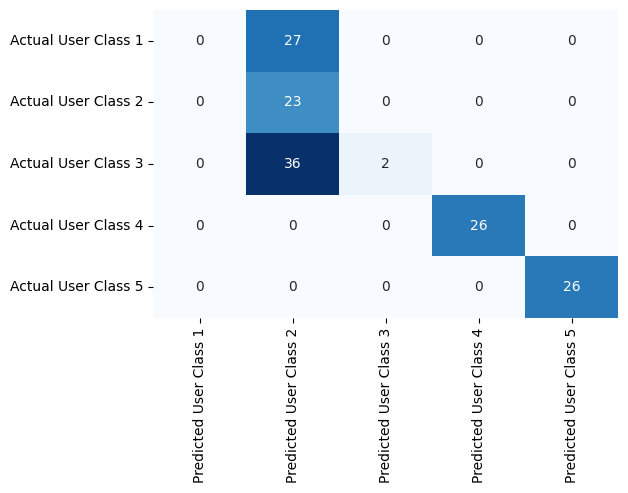

In [109]:
# # Create a confusion matrix heatmap with labels using seaborn
# plt.figure(figsize=(6,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=['Predicted User Class 1', 'Predicted User Class 2', 'Predicted User Class 3', 'Predicted User Class 4', 'Predicted User Class 5'], 
#             yticklabels=['Actual User Class 1', 'Actual User Class 2', 'Actual User Class 3', 'Actual User Class 4', 'Actual User Class 5'])

In [115]:
# # Predict probabilities
# y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# # Coefficients and intercept
# # Create a DataFrame for the coefficients
# coef_df = pd.DataFrame(classifier.coef_, columns=['Numeric Variables Interaction'])
# # Add a row for the intercept (bias term)
# coef_df.loc['Intercept'] = classifier.intercept_
# # Optionally, to make it even more aesthetically pleasing (Jupyter or notebook environments)
# print(coef_df.style.set_caption("Logistic Regression Coefficients").format("{:.4f}").background_gradient(cmap="Blues"))

# # Confusion matrix
# cm = confusion_matrix(Y_test, y_pred)
# print("Confusion Matrix:\n", cm)

# # Generate the classification report as a dictionary
# report = classification_report(Y_test, y_pred, output_dict=True)

# # Plot the heatmap of the classification report
# plt.figure(figsize=(10, 6))
# sns.heatmap(report.iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False)
# plt.title('Classification Report')
# plt.show()

# # Accuracy
# accuracy = accuracy_score(Y_test, y_pred)
# print("Accuracy:", accuracy)

# # Log-loss
# logloss = log_loss(Y_test, y_pred_prob)
# print("Log-Loss:", logloss)

# # # ROC curve and AUC
# # fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
# # plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % roc_auc_score(Y_test, y_pred_prob))
# # plt.plot([0, 1], [0, 1], linestyle='--')
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('ROC Curve')
# # plt.legend()
# # plt.show()

# # AUC Score
# auc = roc_auc_score(Y_test, y_pred_prob)
# print("AUC Score:", auc)


## Conclusion

The purpose of exploring this data set and building a small logistic regression model was to demonstrate some of the key steps when exploring a data sample, as well as the key steps in building a logistic regression model. 

As fancy as machine learning and AI have become,linear and logistic regression models are still widely used in the industry because they are meaningful and impactful in terms of performance. Regression models are easily explainable, which is why they can come in handy in situations where there is a great need to explain why a model is making a certain prediction.

In this project, we looked at the relationships between several different variables on mobile users and their relationship to mobile user behavior class. We also built a logistic regression model that was able to perfectly predict user behavior class on a test data set that the model had not been trained on. Some of the steps that we took in building the logistic regression model to reduce over-fitting and to make sure the model ran were:

1. Turning categorical variables into dummy variables, or numeric representations of the variable that would work as inputs to the model.
2. Checking the model for missingness.
3. Checking to see how correlated the inputs to the model are so that we can avoid multicollinearity.
4. Reducing the input variables in general, which helps avoid overfitting.
5. Using PCA to reduce the dimensionality of the input features, which also helps avoid overfitting.

Having a model that perfectly predicts an outcome can be a sign of over-fitting, in this case likely due to a small sample size. The data sample was also a very clean, easy-to-work-with sample that had no missing values, and some very strong predictors of user behavior class. In the industry, it can be rare to find such clean data samples with obvious predictors. However, running through these steps with this data sample demonstrates how you can approach multi-class prediction problems with other data samples. 
